In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

In [3]:
import matplotlib
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from nuq import NuqClassifier

matplotlib.rcParams.update({"font.size": 12})


def plot_data(X, y, title=None):
    plt.close()
    plt.figure()
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.tight_layout()
    plt.show()


def make_data(total_size=5000, centers=np.array([[-4.0, -4.0], [0.0, 4.0]])):
    X, y = make_blobs(n_samples=total_size, n_features=2, centers=centers)
    return X, y

In [4]:
import ray

# Compare with different parallelism
ray.init()
# ray.init(num_cpus=1)
# ray.init(num_cpus=4)

2021-11-01 20:05:30,322	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.16.112.47',
 'raylet_ip_address': '10.16.112.47',
 'redis_address': '10.16.112.47:46804',
 'object_store_address': '/tmp/ray/session_2021-11-01_20-05-29_048447_23443/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-01_20-05-29_048447_23443/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-11-01_20-05-29_048447_23443',
 'metrics_export_port': 41972,
 'node_id': '3847d0de4189511046e786a7f1a879cd529679d2aa71e0c72ede9fab'}

In [5]:
# Number of points
N = 50000
# Number of classes
k = 3
# Dimensonality
d = 50
tune_bandwidth = "classification:n_folds=10;n_samples=3;verbose=1"

X = np.random.uniform(size=(N, d))
y = np.random.choice(np.arange(k), N)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"{X_train.shape = }, {X_val.shape = }")

nuq = NuqClassifier(n_neighbors=20, tune_bandwidth=tune_bandwidth, verbose=True)
_ = nuq.fit(X_train, y_train)

X_train.shape = (40000, 50), X_val.shape = (10000, 50)


Tuning bandwidth:   0%|          | 0/3 [00:00<?, ?it/s]

  [CLASSIFICATION:N_FOLDS=10;N_SAMPLES=3;VERBOSE=1] bandwidth = 4.080433964729309 (score = 0.33916666666666667)


In [7]:
%%timeit

pred = nuq.predict_proba(X_val, return_uncertainty=False, batch_size=1000)

100%|██████████| 10/10 [00:01<00:00,  6.62it/s]

1.56 s ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Parallelism Comparison

1 core: `4.05 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

vs

4 cores: `1.56 s ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

## Inference on Toy Dataset

X_test.shape = (187248, 2)
  [ISJ] bandwidth = array([0.17221887, 0.25825834])


100%|██████████| 188/188 [00:30<00:00,  6.18it/s]


  [CLASSIFICATION] bandwidth = 0.6341115981340408 (score = 0.9)


100%|██████████| 188/188 [00:24<00:00,  7.56it/s]


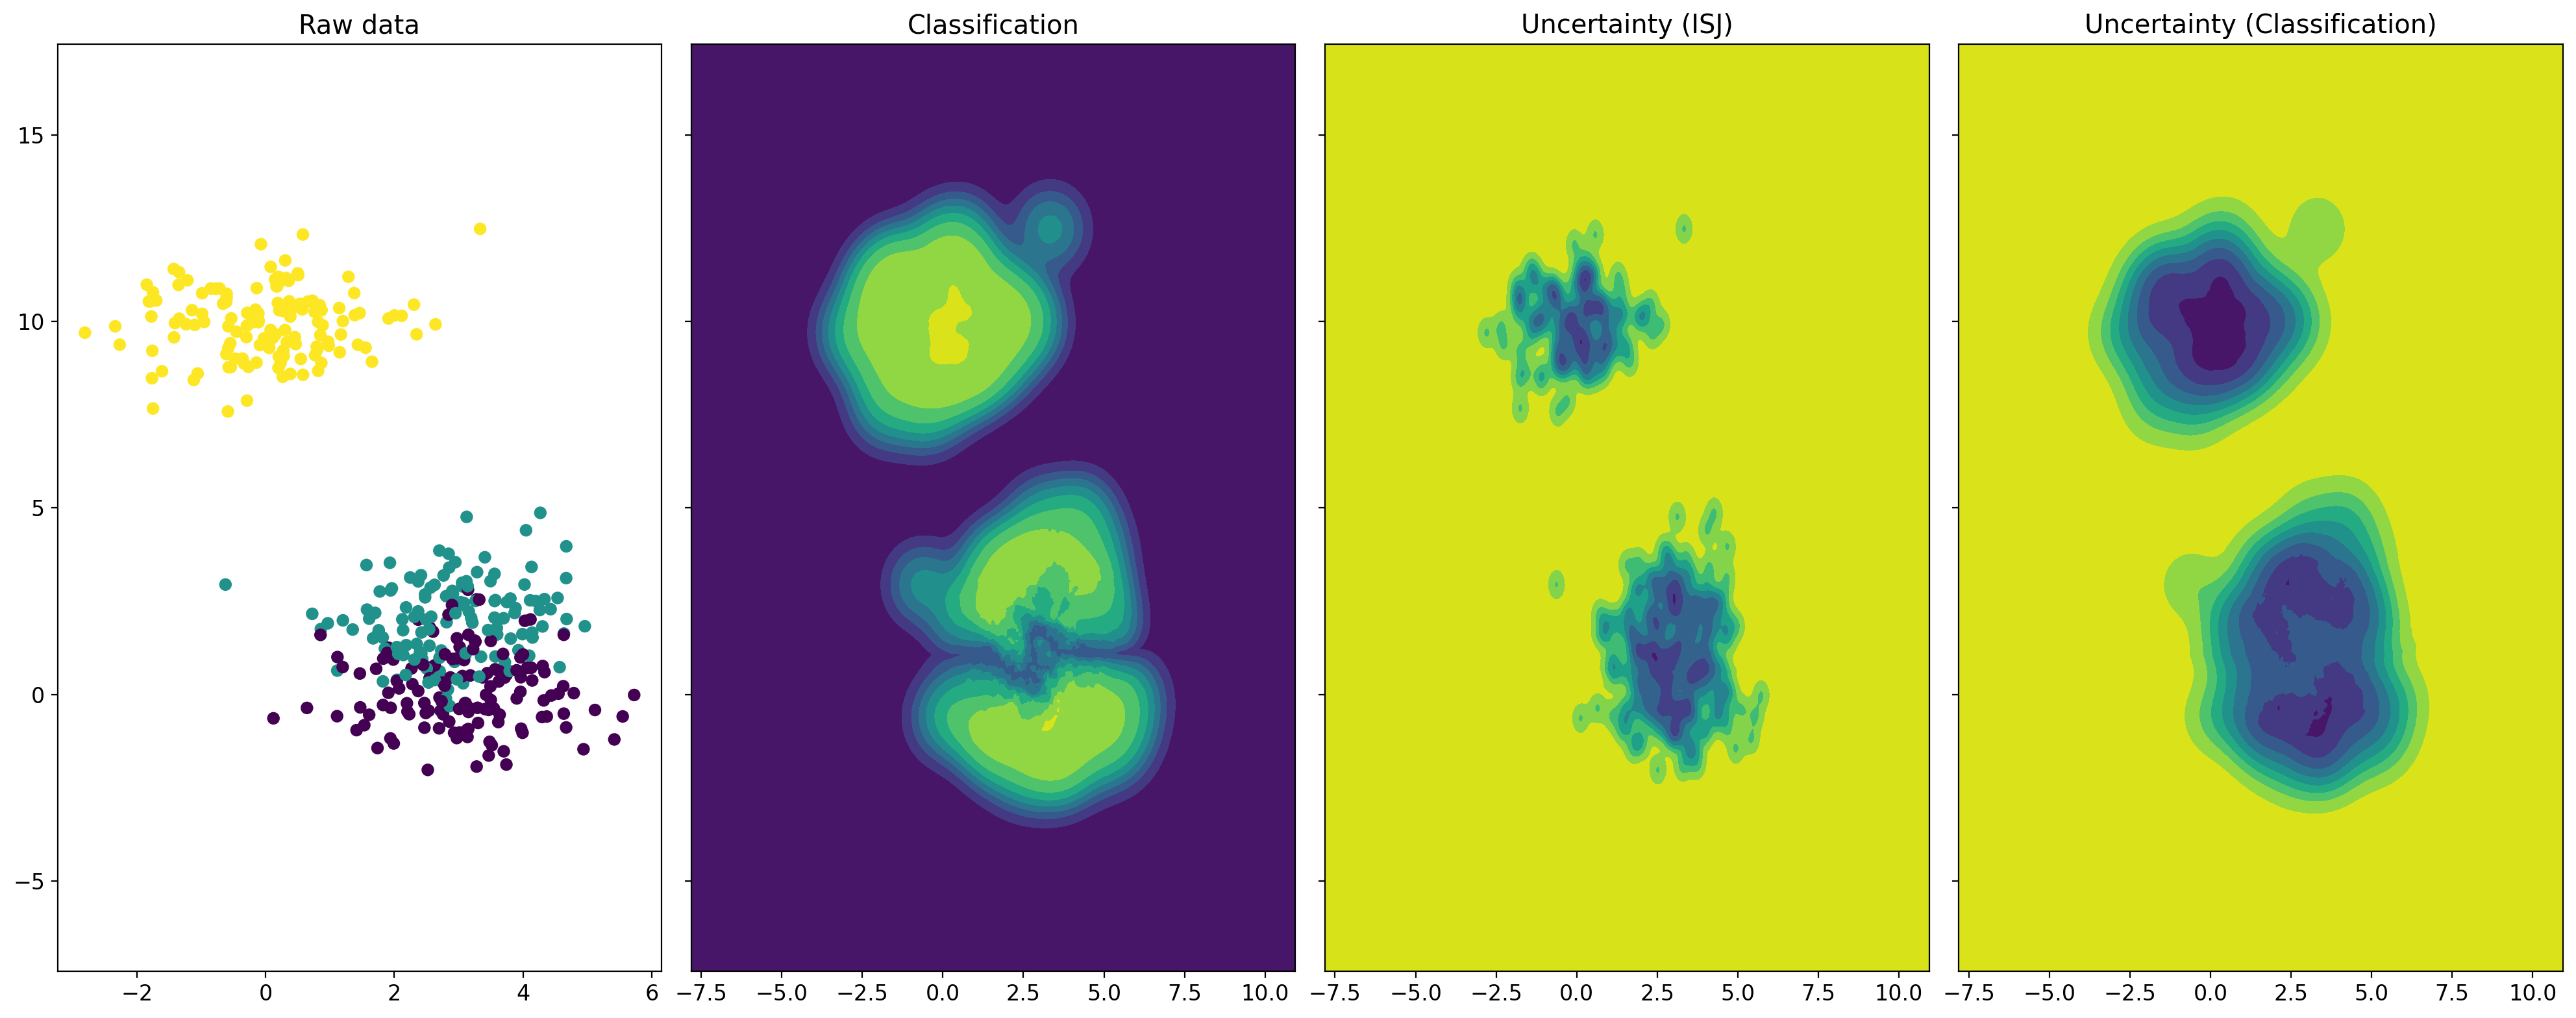

In [43]:
## Make a dataset
X, y = make_data(
    total_size=500,  # total_size=10_000,
    centers=np.array([[3.0, 0.0], [3.0, 2.0], [0.0, 10]]),
)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5

h_x, h_y = [0.05] * 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
X_test = np.c_[xx.ravel(), yy.ravel()]
print(f"{X_test.shape = }")

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), dpi=200, sharey=True)
ax[0].set_title("Raw data")
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)

for i, tune_bandwidth in enumerate(["ISJ", "Classification"]):
    nuq = NuqClassifier(
        tune_bandwidth=tune_bandwidth.lower(),
        kernel_type="RBF",
        n_neighbors=20,
        log_pN=0.0,
        sparse=False,
        verbose=True,
    )
    nuq.fit(X=X_train, y=y_train)

    ax[1].set_title("Classification")
    probs, uncertainty = nuq.predict_proba(X_test, return_uncertainty=True)
    ax[1].contourf(xx, yy, np.max(probs, axis=-1).reshape(*xx.shape))

    ax[i + 2].set_title(f"Uncertainty ({tune_bandwidth})")
    ax[i + 2].contourf(xx, yy, uncertainty.reshape(*xx.shape))

plt.tight_layout()
plt.show()

In [44]:
fig.savefig("nuq_example.pdf")